## Set Up Data

In [2]:
# Import packages
import geopandas as gpd
import rasterio as rio
import matplotlib
import matplotlib.pyplot as plt
import fiona
import pandas as pd
import rioxarray as rxr
import math
import numpy as np
import scipy
from scipy import stats
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.gofplots import ProbPlot

In [2]:
#chunk for installing packages
# !conda install -y statsmodels

EPSG:6514


<Axes: >

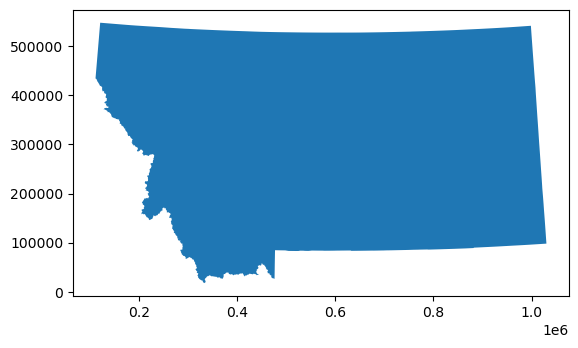

In [2]:
# Load montana shapefile
mt_outline = gpd.read_file('../../Data/mt_shapefile')
print(mt_outline.crs)
mt_outline.plot()

<Axes: >

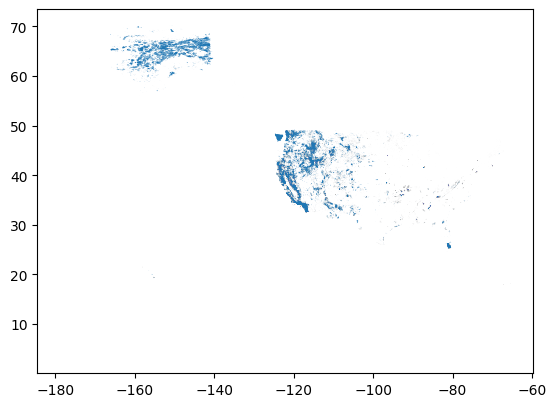

In [4]:
# Load fire polygons, may take a while to load
fire_all = gpd.read_file('../../Data/SHP/')
fire_all.plot()

<Axes: >

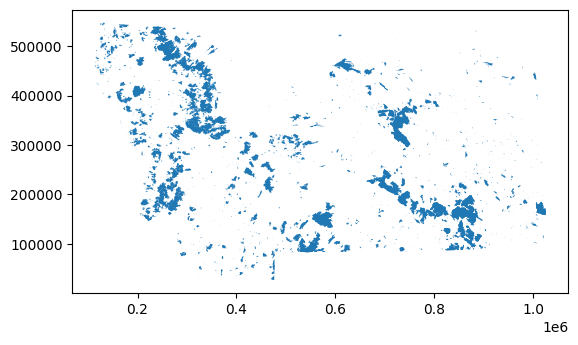

In [10]:
# clip fire polygons to mt
fire_all = fire_all.to_crs('EPSG:6514')
fire_mt = fire_all.clip(mt_outline.geometry)
fire_mt.plot()

In [14]:
# save the clipped fire polygons to a shapefile
# fire_mt.to_file('../../Data/MT_fire_SHP/clipped_shapefile.shp')

<Axes: >

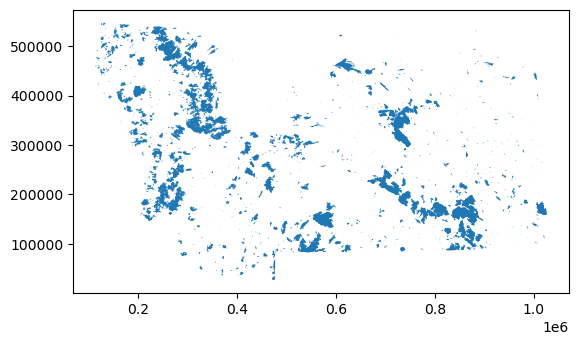

In [5]:
# read the saved shapefile rather than having to re run all of the previous code
fire_mt = gpd.read_file('../../Data/MT_fire_SHP//')
fire_mt.plot()

In [6]:
#create dataframe of the year and total acres burned within montana
table = fire_mt.groupby('FIRE_YEAR')['GIS_ACRES'].sum().reset_index()

#change year from string to number
table['FIRE_YEAR'] = table['FIRE_YEAR'].astype('float64')

#filter out bad data
firetable = table[table['FIRE_YEAR'] != 9999]
firetable = firetable[firetable['FIRE_YEAR'] > 1976]
firetable

,FIRE_YEAR,GIS_ACRES
46,1977.0,6.245481e+01
47,1978.0,8.422123e+02
48,1979.0,4.398650e+02
49,1980.0,3.249464e+03
50,1981.0,5.112134e+03
51,1982.0,9.806478e+03
52,1983.0,6.757798e+02
53,1984.0,4.465364e+04
54,1985.0,7.004646e+04
55,1986.0,2.369844e+03


In [7]:
# read in ENSO data as a dataframe
ENSO = pd.read_csv('../../Data/ENSO.csv')
#filter out irrelevant years
ENSO = ENSO[ENSO['Year'] < 2022]
ENSO = ENSO[ENSO['Year'] > 1976]
ENSO

,Year,DJF,JFM,FMA,MAM,AMJ,MJJ,JJA,JAS,ASO,SON,OND,NDJ
27,1977,0.7,0.6,0.3,0.2,0.2,0.3,0.4,0.4,0.6,0.7,0.8,0.8
28,1978,0.7,0.4,0.1,-0.2,-0.3,-0.3,-0.4,-0.4,-0.4,-0.3,-0.1,0.0
29,1979,0.0,0.1,0.2,0.3,0.2,0.0,0.0,0.2,0.3,0.5,0.5,0.6
30,1980,0.6,0.5,0.3,0.4,0.5,0.5,0.3,0.0,-0.1,0.0,0.1,0.0
31,1981,-0.3,-0.5,-0.5,-0.4,-0.3,-0.3,-0.3,-0.2,-0.2,-0.1,-0.2,-0.1
32,1982,0.0,0.1,0.2,0.5,0.7,0.7,0.8,1.1,1.6,2.0,2.2,2.2
33,1983,2.2,1.9,1.5,1.3,1.1,0.7,0.3,-0.1,-0.5,-0.8,-1.0,-0.9
34,1984,-0.6,-0.4,-0.3,-0.4,-0.5,-0.4,-0.3,-0.2,-0.2,-0.6,-0.9,-1.1
35,1985,-1.0,-0.8,-0.8,-0.8,-0.8,-0.6,-0.5,-0.5,-0.4,-0.3,-0.3,-0.4
36,1986,-0.5,-0.5,-0.3,-0.2,-0.1,0.0,0.2,0.4,0.7,0.9,1.1,1.2


In [8]:
# caclulate average ONI per year
ENSO['AverageONI'] = ENSO[['DJF','JFM','FMA','MAM','AMJ','JJA','JAS','ASO','SON','OND','NDJ']].mean(axis=1)

# combine ENSO and fire data into a single geodataframe

ENSOfire = pd.merge(ENSO, firetable, left_on='Year', right_on = 'FIRE_YEAR')
# log transform the burned area data in order to perform stat analysis
ENSOfire['GIS_ACRESlog'] = np.log(ENSOfire['GIS_ACRES'])
# ENSOfire['AvgONIlog'] = np.log(ENSOfire['AverageONI'])
ENSOfire


# Save to a csv

# ENSOfire.to_csv('../../Data/ENSOfire.csv')

,Year,DJF,JFM,FMA,MAM,AMJ,MJJ,JJA,JAS,ASO,SON,OND,NDJ,AverageONI,FIRE_YEAR,GIS_ACRES,GIS_ACRESlog
0,1977,0.7,0.6,0.3,0.2,0.2,0.3,0.4,0.4,0.6,0.7,0.8,0.8,0.518182,1977.0,6.245481e+01,4.134443
1,1978,0.7,0.4,0.1,-0.2,-0.3,-0.3,-0.4,-0.4,-0.4,-0.3,-0.1,0.0,-0.081818,1978.0,8.422123e+02,6.736032
2,1979,0.0,0.1,0.2,0.3,0.2,0.0,0.0,0.2,0.3,0.5,0.5,0.6,0.263636,1979.0,4.398650e+02,6.086468
3,1980,0.6,0.5,0.3,0.4,0.5,0.5,0.3,0.0,-0.1,0.0,0.1,0.0,0.236364,1980.0,3.249464e+03,8.086245
4,1981,-0.3,-0.5,-0.5,-0.4,-0.3,-0.3,-0.3,-0.2,-0.2,-0.1,-0.2,-0.1,-0.281818,1981.0,5.112134e+03,8.539372
5,1982,0.0,0.1,0.2,0.5,0.7,0.7,0.8,1.1,1.6,2.0,2.2,2.2,1.036364,1982.0,9.806478e+03,9.190799
6,1983,2.2,1.9,1.5,1.3,1.1,0.7,0.3,-0.1,-0.5,-0.8,-1.0,-0.9,0.454545,1983.0,6.757798e+02,6.515867
7,1984,-0.6,-0.4,-0.3,-0.4,-0.5,-0.4,-0.3,-0.2,-0.2,-0.6,-0.9,-1.1,-0.500000,1984.0,4.465364e+04,10.706691
8,1985,-1.0,-0.8,-0.8,-0.8,-0.8,-0.6,-0.5,-0.5,-0.4,-0.3,-0.3,-0.4,-0.600000,1985.0,7.004646e+04,11.156914
9,1986,-0.5,-0.5,-0.3,-0.2,-0.1,0.0,0.2,0.4,0.7,0.9,1.1,1.2,0.263636,1986.0,2.369844e+03,7.770579


## Linear Regression

Assumptions for performing a linear regression:
1. Independance: No reason to believe there isn't independance of observations

3. Linearity: The residuals appear to be randomly scattered (there is no observable relationship) in the RvF plot providing weak evidence against linearity.
   
4. Constant Variance: The spread of residuals in the RvF plot is relatively similar across the field values, although there is certainly more vertical spread in the center of the plot. This provides moderate evidence against the assumtion of constant variance.
   
5. Normality: There are very few deviations from the line of normality in the normal q-q plot, suggesting weak evidence against normality.

6. No influential observations: There is only one residual with relatively high leverage (38), and there are no residuals with cook's D above 0.5, so there are no influential observations


In [7]:
# Chunk for doing stat analysis regarding above descriptions

model_f = 'GIS_ACRESlog ~ AverageONI'

model = smf.ols(formula=model_f, data=ENSOfire)
model_fit = model.fit()

# fitted values (need a constant term for intercept)
model_fitted_y = model_fit.fittedvalues

# model residuals
model_residuals = model_fit.resid

# normalized residuals
model_norm_residuals = model_fit.get_influence().resid_studentized_internal

# absolute squared normalized residuals
model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))

# absolute residuals
model_abs_resid = np.abs(model_residuals)

# leverage, from statsmodels internals
model_leverage = model_fit.get_influence().hat_matrix_diag

# cook's distance, from statsmodels internals
model_cooks = model_fit.get_influence().cooks_distance[0]


C:\Users\mount\miniconda3\envs\491project\Lib\site-packages\statsmodels\graphics\gofplots.py:1045: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


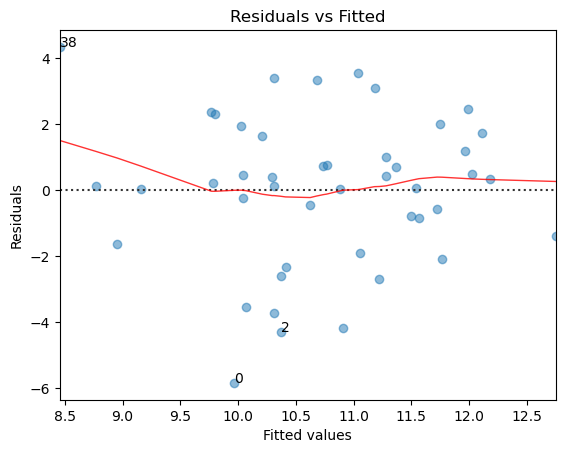

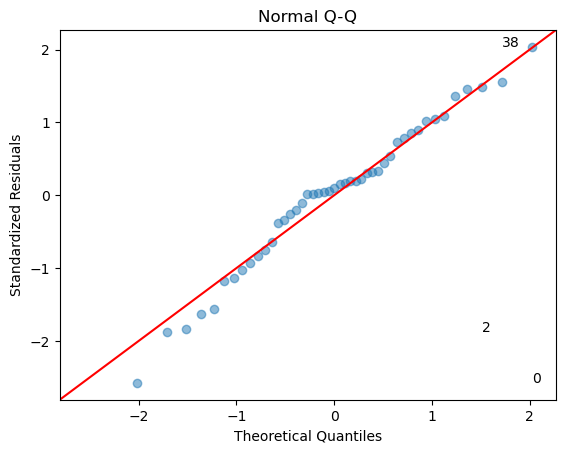

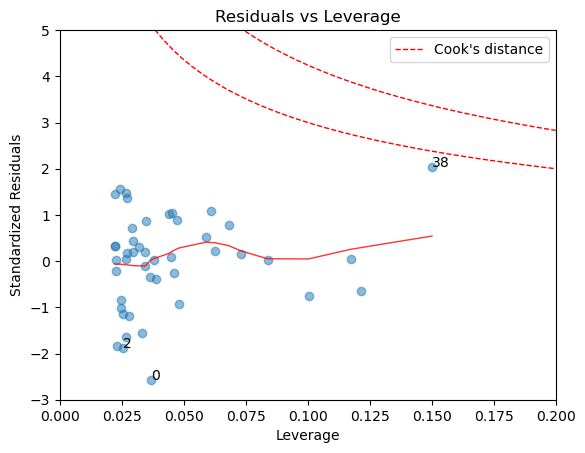

In [8]:
# Chunk for plotting regression plots

# Resid. vs Fitted

plot_lm_1 = plt.figure(1)

plot_lm_1.axes[0] = sns.residplot(data=ENSOfire, x=model_fitted_y, y='GIS_ACRESlog', 
                          lowess=True, 
                          scatter_kws={'alpha': 0.5}, 
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plot_lm_1.axes[0].set_title('Residuals vs Fitted')
plot_lm_1.axes[0].set_xlabel('Fitted values')
plot_lm_1.axes[0].set_ylabel('Residuals')

# annotations
abs_resid = model_abs_resid.sort_values(ascending=False)
abs_resid_top_3 = abs_resid[:3]

for i in abs_resid_top_3.index:
    plot_lm_1.axes[0].annotate(i, 
                               xy=(model_fitted_y[i], 
                                   model_residuals[i]));

# QQ Norm

QQ = ProbPlot(model_norm_residuals)
plot_lm_2 = QQ.qqplot(line='45', alpha=0.5, color='#4C72B0', lw=1)

plot_lm_2.axes[0].set_title('Normal Q-Q')
plot_lm_2.axes[0].set_xlabel('Theoretical Quantiles')
plot_lm_2.axes[0].set_ylabel('Standardized Residuals');

# annotations
abs_norm_resid = np.flip(np.argsort(np.abs(model_norm_residuals)), 0)
abs_norm_resid_top_3 = abs_norm_resid[:3]

for r, i in enumerate(abs_norm_resid_top_3):
    plot_lm_2.axes[0].annotate(i, 
                               xy=(np.flip(QQ.theoretical_quantiles, 0)[r],
                                   model_norm_residuals[i]));

# leverage Plot

plot_lm_4 = plt.figure(4)

plt.scatter(model_leverage, model_norm_residuals, alpha=0.5)
sns.regplot(x=model_leverage, y=model_norm_residuals, 
            scatter=False, 
            ci=False, 
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plot_lm_4.axes[0].set_xlim(0, 0.20)
plot_lm_4.axes[0].set_ylim(-3, 5)
plot_lm_4.axes[0].set_title('Residuals vs Leverage')
plot_lm_4.axes[0].set_xlabel('Leverage')
plot_lm_4.axes[0].set_ylabel('Standardized Residuals')

# annotations
leverage_top_3 = np.flip(np.argsort(model_cooks), 0)[:3]

for i in leverage_top_3:
    plot_lm_4.axes[0].annotate(i, 
                               xy=(model_leverage[i], 
                                   model_norm_residuals[i]))
    
# shenanigans for cook's distance contours
def graph(formula, x_range, label=None):
    x = x_range
    y = formula(x)
    plt.plot(x, y, label=label, lw=1, ls='--', color='red')

p = len(model_fit.params) # number of model parameters

graph(lambda x: np.sqrt((0.5 * p * (1 - x)) / x), 
      np.linspace(0.001, 0.200, 50), 
      'Cook\'s distance') # 0.5 line
graph(lambda x: np.sqrt((1 * p * (1 - x)) / x), 
      np.linspace(0.001, 0.200, 50)) # 1 line
plt.legend(loc='upper right');


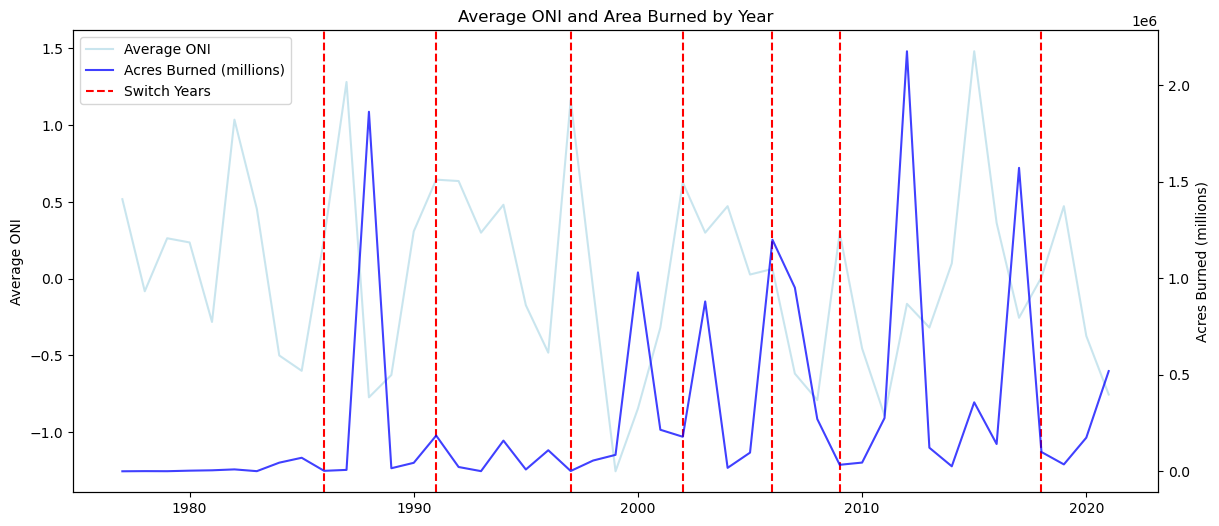

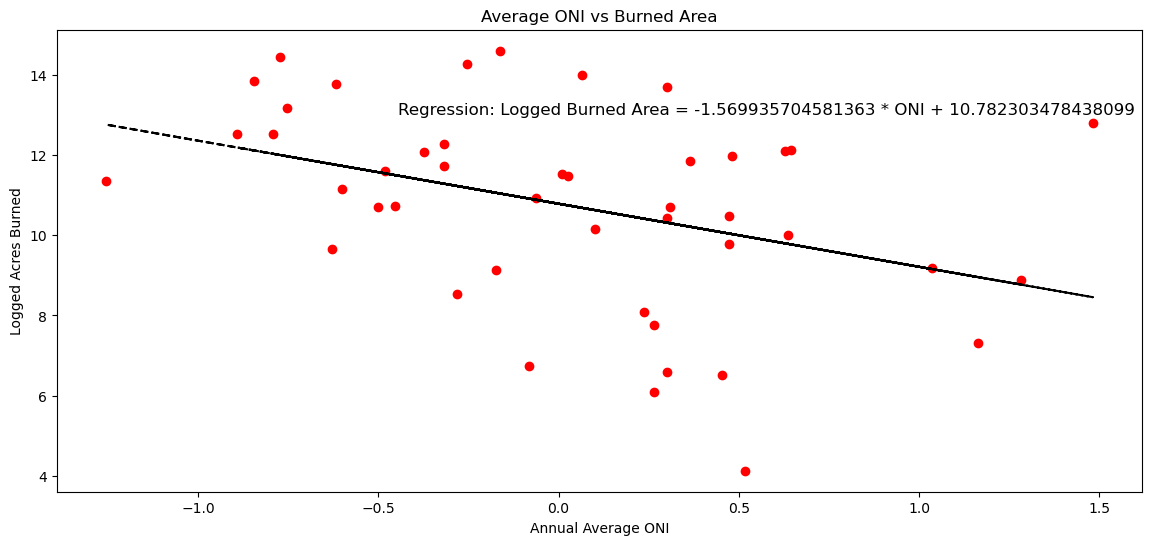

In [10]:
# Create new figure
fig, ax1 = plt.subplots(figsize=(14,6))

# Plot the first line on ax1
line1, = ax1.plot(ENSOfire['Year'], ENSOfire['AverageONI'], color='lightblue', alpha=0.65, label='Average ONI')
ax1.set_ylabel('Average ONI')

# Create a second y-axis that shares the same x-axis
ax2 = ax1.twinx()

# Plot the second line on ax2
line2, = ax2.plot(ENSOfire['FIRE_YEAR'], ENSOfire['GIS_ACRES'], color='blue', alpha=0.75, label='Acres Burned (millions)')
ax2.set_ylabel('Acres Burned (millions)')

years_of_interest = [1986, 1991, 1997, 2002, 2006, 2009, 2018]

for year in years_of_interest:
    vline = ax1.axvline(x=year, color='red', linestyle='--', label='Switch Years')

# Create a legend
ax1.legend(handles=[line1, line2, vline], loc='upper left')

#Title
ax1.set_title('Average ONI and Area Burned by Year')

# Create a third subplot for the scatter plot
fig, ax3 = plt.subplots(figsize=(14,6))
ax3.scatter(ENSOfire['AverageONI'], ENSOfire['GIS_ACRESlog'],color='red')

# Title
ax3.set_title('Average ONI vs Burned Area')
ax3.set_ylabel('Logged Acres Burned')
ax3.set_xlabel('Annual Average ONI')

# Perform a linear regression
linregres = scipy.stats.linregress(x=ENSOfire['AverageONI'], y=ENSOfire['GIS_ACRESlog'], alternative='two-sided')

# Plot the linear regression line and equation on the figure
regy =  linregres[0] * ENSOfire['AverageONI'] + linregres[1]
ax3.plot(ENSOfire['AverageONI'], regy, color='black', linestyle='--')
equation_text = f'Regression: Logged Burned Area = {linregres[0]} * ONI + {linregres[1]}'
plt.text(1.6,13,equation_text, fontsize=12, ha='right')

# Show the plot
plt.show()

In [18]:
# Code for summarizing linear regression (note the R^2)
X = sm.add_constant(ENSOfire['GIS_ACRESlog'])
Y = ENSOfire['AverageONI']
model = sm.OLS(Y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:             AverageONI   R-squared:                       0.151
Model:                            OLS   Adj. R-squared:                  0.132
Method:                 Least Squares   F-statistic:                     7.669
Date:                Mon, 29 Apr 2024   Prob (F-statistic):            0.00826
Time:                        15:35:54   Log-Likelihood:                -37.673
No. Observations:                  45   AIC:                             79.35
Df Residuals:                      43   BIC:                             82.96
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            1.0619      0.384      2.769   

## Difference of Means

Question:

Is the true mean area burned during La Nina to El Nino switch years greater than the true mean area burned during other years.

Hypotheses:

$H_0: \mu_{switch}-\mu_{other}=0$

$H_a: \mu_{switch}-\mu_{other}>0$

In [8]:
# load the data
ENSOfire = pd.read_csv('../../Data/ENSOfire.csv')

In [9]:
# set up the dataframe with switch year values (yes or no)
ENSOfire['SwitchYear'] = 'no'
# following lines assign 'yes' to years that experienced a switch from La Nina (neg. ONI) to El Nino (pos. ONI) (if the switch occurred over multiple years 'no' was retained, as well as if the switch was not "official")
ENSOfire.loc[9, 'SwitchYear'] = 'yes'
ENSOfire.loc[14, 'SwitchYear'] = 'yes'
ENSOfire.loc[20, 'SwitchYear'] = 'yes'
ENSOfire.loc[25, 'SwitchYear'] = 'yes'
ENSOfire.loc[29, 'SwitchYear'] = 'yes'
ENSOfire.loc[32, 'SwitchYear'] = 'yes'
ENSOfire.loc[41, 'SwitchYear'] = 'yes'

ENSOfire

,Unnamed: 0,Year,DJF,JFM,FMA,MAM,AMJ,MJJ,JJA,JAS,ASO,SON,OND,NDJ,AverageONI,FIRE_YEAR,GIS_ACRES,GIS_ACRESlog,SwitchYear
0,0,1977,0.7,0.6,0.3,0.2,0.2,0.3,0.4,0.4,0.6,0.7,0.8,0.8,0.518182,1977.0,6.245481e+01,4.134443,no
1,1,1978,0.7,0.4,0.1,-0.2,-0.3,-0.3,-0.4,-0.4,-0.4,-0.3,-0.1,0.0,-0.081818,1978.0,8.422123e+02,6.736032,no
2,2,1979,0.0,0.1,0.2,0.3,0.2,0.0,0.0,0.2,0.3,0.5,0.5,0.6,0.263636,1979.0,4.398650e+02,6.086468,no
3,3,1980,0.6,0.5,0.3,0.4,0.5,0.5,0.3,0.0,-0.1,0.0,0.1,0.0,0.236364,1980.0,3.249464e+03,8.086245,no
4,4,1981,-0.3,-0.5,-0.5,-0.4,-0.3,-0.3,-0.3,-0.2,-0.2,-0.1,-0.2,-0.1,-0.281818,1981.0,5.112134e+03,8.539372,no
5,5,1982,0.0,0.1,0.2,0.5,0.7,0.7,0.8,1.1,1.6,2.0,2.2,2.2,1.036364,1982.0,9.806478e+03,9.190799,no
6,6,1983,2.2,1.9,1.5,1.3,1.1,0.7,0.3,-0.1,-0.5,-0.8,-1.0,-0.9,0.454545,1983.0,6.757798e+02,6.515867,no
7,7,1984,-0.6,-0.4,-0.3,-0.4,-0.5,-0.4,-0.3,-0.2,-0.2,-0.6,-0.9,-1.1,-0.500000,1984.0,4.465364e+04,10.706691,no
8,8,1985,-1.0,-0.8,-0.8,-0.8,-0.8,-0.6,-0.5,-0.5,-0.4,-0.3,-0.3,-0.4,-0.600000,1985.0,7.004646e+04,11.156914,no
9,9,1986,-0.5,-0.5,-0.3,-0.2,-0.1,0.0,0.2,0.4,0.7,0.9,1.1,1.2,0.263636,1986.0,2.369844e+03,7.770579,yes


<Axes: xlabel='SwitchYear', ylabel='GIS_ACRESlog'>

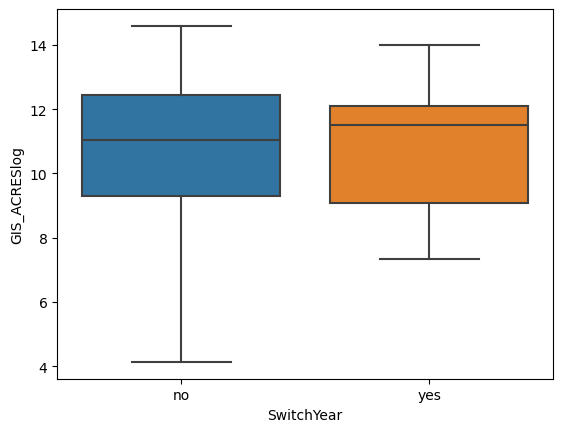

In [10]:
# boxplot
sns.boxplot(x='SwitchYear', y='GIS_ACRESlog', data=ENSOfire, whis=np.inf)

C:\Users\mount\miniconda3\envs\491project\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\mount\miniconda3\envs\491project\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='GIS_ACRESlog', ylabel='Count'>

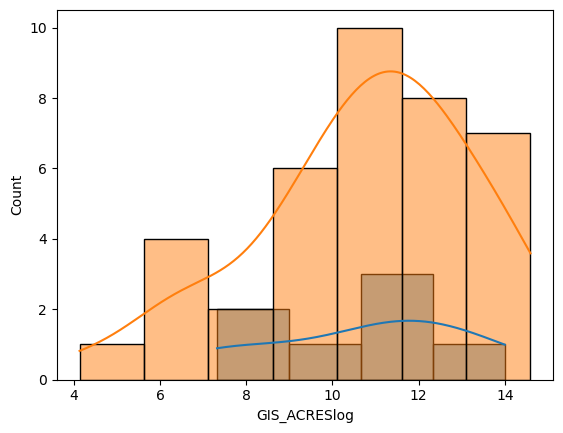

In [11]:
# histrograms
switch = ENSOfire[ENSOfire['SwitchYear'] == 'yes']
nonswitch = ENSOfire[ENSOfire['SwitchYear'] == 'no']
sns.histplot(data=switch, x='GIS_ACRESlog', kde=True)
sns.histplot(data=nonswitch, x='GIS_ACRESlog', kde=True)

In [12]:
std = ENSOfire.groupby('SwitchYear')['GIS_ACRESlog'].std()
std

SwitchYear
no     2.515876
yes    2.434093
Name: GIS_ACRESlog, dtype: float64

### Assumptions for Difference of Means:

Since the standard deviations are similar, we can assume equal variance. Since the histograms show relatively symmetric shape, we can assume normality. We have no reason to believe observations are not independant.

In [13]:
# Perform t test
t_stat, p_val = stats.ttest_ind(switch['GIS_ACRESlog'], nonswitch['GIS_ACRESlog'], alternative='greater')

# Print the t-statistic and p-value
print(f"t-statistic: {t_stat}")
print(f"one-sided p-value: {p_val}")

t-statistic: 0.009870214123793793
one-sided p-value: 0.4960852441283813


In [14]:
means = ENSOfire.groupby('SwitchYear')['GIS_ACRESlog'].mean()
means

SwitchYear
no     10.739174
yes    10.749342
Name: GIS_ACRESlog, dtype: float64

## Conclusions

There is strong evidence to suggest that there is a linear relationship between annual mean ONI and the true mean logged annual burned area in Montana. Although the $R^2$ indicates only 15.1% of total variation is captured by the relationship. ($t_{43}=-2.769$, two-sided p-value$=0.008$)

There is very weak evidence to suggest that the true mean logged area burned for fires that occurred during La Nina -> El Nino switch years is greater than the true mean logged area burned during non-switch years. ($t_{43}=0.010$, one-sided p-value$=0.496$)

Associations (non-causal) can only be inferred to the sample, since there could be bias involved in the sampling of fires within the dataset I obtained. Random assignment also did not occur, as this was an observational study.

## Sources

Wildfire data: https://data-nifc.opendata.arcgis.com/datasets/nifc::interagencyfireperimeterhistory-all-years-view/about 

ENSO data: https://origin.cpc.ncep.noaa.gov/products/analysis_monitoring/ensostuff/ONI_v5.php

Emulating R regression plots: https://emredjan.medium.com/emulating-r-regression-plots-in-python-43741952c034

